In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [75]:
df = pd.read_csv('dataset.csv', names=('text', 'label'))[1:]
df['text'] = df['text'].str.lower().str.split()
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
train_data, test_data = train_test_split(df, test_size=.2)
vocab = {word for phrase in df['text'] for word in phrase}
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
max_length = df['text'].str.len().max()

def encode_and_pad(text):
    encoded = [word_to_idx[word] for word in text]
    return [0]*(max_length-len(encoded)) + encoded

train_data['text'] = train_data['text'].apply(encode_and_pad)
test_data['text'] = test_data['text'].apply(encode_and_pad)

In [103]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)
    
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [104]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [1:15:18<00:00, 451.80s/it]


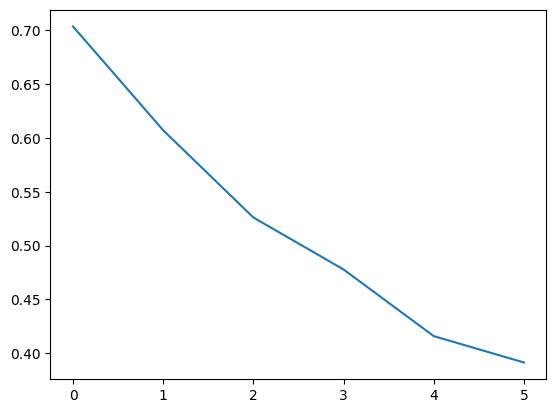

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 10
log = []

for i in tqdm(range(n_epochs)):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    log.append(epoch_loss/len(train_loader))

plt.plot(range(len(log)), log)
plt.show()

In [106]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for texts, labels in tqdm(test_loader):
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100*correct/total
print('accuracy:', accuracy)

100%|██████████| 313/313 [00:35<00:00,  8.81it/s]

accuracy: 49.75
